<img src="./pictures/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" /></a>

# Design graphs for the sizing a DC/DC converter
*Written by Marc Budinger, INSA Toulouse, France*

The purpose of this notebook is to structure the sizing procedure of the DC / DC converter.

In general, the establishment of a sizing procedure involves the resultion of the following 3 problems:
* a set of equations sub-constrained by the addition of a design variable in the optimization problem;
* an over-constrained variable by adding a design variable (multiplier) and the transfer of the excess equation(s) in the constrained part of the optimization problem;
* an algebraic loop by the use of a simplify equation weighted by a multiplying coefficient and a constraint representing the initial equation.



Where possible:
* the design variables must take the form of a normalized variable around 1 (oversize coef. for example) or easily bounded to facilitate the work of the optimization algorithm.
* the constraints must take the form of inequality and not of equality more difficult to manage. The optimization of the objective (for example the total mass) will certainly force some (active) constraints to come to an end. 

## Means objective network

The purpose of the sizing will be to minimize the mass of the converter. The following graph shows that this mass depends mainly on the losses of the converter by the mass of the dissipator. The switching frequency also influences the mass of the filtering portion of the converter and the switching losses. The latter will therefore be chosen as an optimization variable.

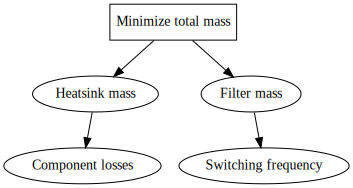

In [3]:
# Plot the WBS of the system
from graphviz import Digraph

dot = Digraph(comment='Means objective network')
# Main objective
dot.node('O', 'Minimize total mass', shape='rectangle')
# Influence by
dot.node('SO1', 'Heatsink mass')
dot.node('SO2', 'Filter mass')

dot.edge('O','SO1')
dot.edge('O','SO2')

# Influence by
dot.node('V1', 'Component losses')
dot.node('V2', 'Switching frequency')

dot.edge('SO1','V1')
dot.edge('SO2','V2')

# Render the graph into the notebook

dot


## Thermal sizing scenario

### Design graph

The following figure shows the design graph of a part of the equations representing the calculation of the temperatures of the various components of the DC/DC converter.

![Graphic Thermal Design](pictures/IGBT_design_graph.png)

> Exercise: analyze the design graph and show that there is an algebraic-loop and over-constraints. Propose solutions for these problems.


### Optimization problem: synthesis

> Exercice: synthesis here the design variables and the constraints which have to be add to the DC/DC converter optimization problem.

![PseudoCode](pictures/PseudoCodeInductor.png)



### Sizing code and optimization

> Exercice: propose a sizing code and a optimization loop for the selection of an IGBT module & a heatsink.

The specifications and design assumptions are the following:


In [38]:
# DC/DC converter Specifications
E=150 # [V] DC bus voltage
IL=140 # [A] DC current of the load
UL=62.25 # [V] DC voltage of the load

 
# Design Assumptions
T_amb=40 # [°C] Ambient temperature
DE=E*.01 # [V] Max ripple voltage DC bus
DIL=IL*.35 # [A] Max ripple current

f=10e3 # [Hz] switching frequency
Lhs=150 # [mm] Heatsink length

For the technical data about the IGBT switchs you have here an example of datasheet for a [reference component](IXYN80N90C3H1.pdf).

##### IGBT

|                | Scaling laws  | References |
| -------------- | --------------| -----------|
| Definition parameter : |       |            |
| Current | $I$ | $80 A$ |
|Maximum voltage | $V_{max}^* = 1$ | $900 V$ |
| Voltage drop | $V_0^*=1$ | $1 V$ | 
| Dynamic resistance | $R_0^*=I^{*-1}$ | 20 m${\Omega}$ |
| Commutation losses | $(E_{on}+E_{off})^*=I^* E^*$ | $8.2 mJ$ for $E=450 V$ |
| Thermal resistance | $R_{th_JC}^*=I^{*-1}$ | $0.30 °C/W$ |

##### Diode (Current evolution equal to IGBT current) 


|                | Scaling laws  | References |
| -------------- | --------------| -----------|
| Definition parameter : |       |            |
| Current | $I$ | $41 A$ |
| Maximum voltage | $V_{max}^* = 1$ | $900 V$ |
| Voltage drop | $V_0^*=1$ | $1 V$ | 
| Dynamic resistance | $R_0^*=I^{*-1}$ | $15 m\Omega$ |
| Commutation losses | $t_{rr}I_{RM}^{*}=I^*E^*$ | $17.2 mJ$ for $E=600 V$ |
| Thermal resistance | $R_{th_JC}^{*}=I^{*-1}$ | $0.47 °C/W$ |

More details about the technical informations can be found [here](http://www.ixyspower.com/images/technical_support/Application%20Notes%20By%20Topic/General%20Topics/IXAN0056.pdf).
    
 

In [39]:
import numpy as np
import scipy
import scipy.optimize
from math import pi, sqrt
import timeit


def SizingDCDC(param, arg):
    # Variables
    # ----------------------------------------
    #-
    T_H=param[0] # [°C] Heatsink temperature (Heatsink)
    W_H=param[1] # [°C] Width W / Height H aspect ratio (Heatsink)
    #-
    k_IGBT=param[2] # [-] Oversizing coefficient (IGBT)

    
    # Main electrical equations
    # ----------------------------------------
    
    # Global
    
    Alpha=UL/E # [-] Duty cycle
    T=1/f # [s] PWM period
    
    # Filter: Inductor & Capacitor
    L=E*Alpha*(1-Alpha)*T/DIL  # [H] Inductance value
    C=IL*Alpha*(1-Alpha)*T/DE  # [F] Capcitance value
        
    # RMS and mean value
    
    IL_max = IL + DIL/2 # [A] Max current (load side) Inductor
    IL_RMS = IL*sqrt(1+1/12*(DIL/IL)**2) # [A] RMS current (load side) Inductor
    
    IC_RMS = sqrt(Alpha*(1-Alpha))*IL_RMS # [A] RMS current Capacitor
    
    I_IGBT_RMS=sqrt(Alpha)*IL_RMS # [A] RMS current IGBT
    I_IGBT_mean=Alpha*IL # [A] mean current IGBT
    
    I_Diode_RMS=sqrt(1-Alpha)*IL_RMS  # [A] RMS current Diode
    I_Diode_mean=(1-Alpha)*IL  # [A] mean current Diode
     
   
    # ----------------------------------------
    # IGBT module IXYS: 900V max
    
    I_IGBT_ref=80 # [A] Ref Current of the module
    V0_IGBT_ref=1 #[V] voltage drop 
    R0_IGBT_ref=20e-3 # [Ohm] dynamic resistance
    Ecom_IGBT_ref=8.2e-3 # [J] commutation energy ref
    E_IGBT_ref=600 # [V] ref voltage for commutation loss
    Rth_IGBT_ref=0.3 # [°C/W] thermal resistance
    
    T_max_IGBT=120 # [°C] max temeprature
        
    # current estimation
    I0=k_IGBT*I_IGBT_RMS 
    
    # IGBT scaling
    V0_IGBT=V0_IGBT_ref #[V] voltage drop 
    R0_IGBT=R0_IGBT_ref*(I0/I_IGBT_ref)**(-1) # [Ohm] R0*=I*^-1
    Ecom_IGBT=Ecom_IGBT_ref*(I0*E/(I_IGBT_ref*E_IGBT_ref)) # [J] commutation energy (Eon+Eoff)*=I*E*
    Rth_IGBT=Rth_IGBT_ref*(I0/I_IGBT_ref)**(-1) # [°/W] Rth*=I*^(-1)
    
    # Thermal calculation
    Ploss_IGBT=V0_IGBT*I_IGBT_mean+R0_IGBT*I_IGBT_RMS**2+f*Ecom_IGBT # [W] IGBT losses
    T_hot_IGBT=T_H + Ploss_IGBT*Rth_IGBT # [°C] IGBT junction temperature
    
    # Diode of IGBT module IXYS : 900V max  
      
    I_Diode_ref=41 # [A] Ref Current of the module
    V0_Diode_ref=1 #[V] voltage drop 
    R0_Diode_ref=15e-3 # [Ohm] dynamic resistance
    QrrE_ref=17.2e-3 # [J] commutation energy
    Rth_Diode_ref=0.47 # [°C/W] thermal resistance

    # Diode scaling
    V0_Diode=V0_Diode_ref #[V] voltage drop 
    R0_Diode=R0_Diode_ref*(I0/I_IGBT_ref)**(-1) # [Ohm] R0*=I*^-1
    QrrE=QrrE_ref*(I0*E/(I_IGBT_ref*E_IGBT_ref)) # [J] commutation energy (trrIrm)*=I*E*
    Rth_Diode=Rth_Diode_ref*(I0/I_IGBT_ref)**(-1) # [°/W] Rth*=I*^(-1)

    # Thermal calculation
    Ploss_Diode=V0_Diode*I_Diode_mean+R0_Diode*I_Diode_RMS**2+f*QrrE # [W] Diode losses
    T_hot_Diode=T_H + Ploss_Diode*Rth_Diode  # [°C] Hot spot temperature       
    
    # ----------------------------------------
    # Heatsink : forced convection (2m/s)
 
    # Rth,f = 150*W**(-0.85)*H**(-0.62)*36.7*L**(-0.72) # [°/W] thermal resistance with W,H,L in mm
    # Rth,f = 5505*H**(-1.47)*W_H**(-0.85)*L**(-0.72)
    RthH=(T_H-T_amb)/(Ploss_Diode+Ploss_IGBT) # [°/W] Thermal resistance target
    Hhs=(RthH/5505/Lhs**(-0.72)/W_H**(-0.85))**(-1/1.47) # [mm] Height 
    Whs=Hhs*W_H # [mm] Width
    M_H=0.00263*Whs**0.91*Hhs**0.89*(Lhs/1e3)  # [kg] heatsink mass with W,H,L in mm
    
    # ----------------------------------------
    # Total mass
    
    M_total=M_H
    
    # Objective and contraints
    if arg=='Obj':
        return M_total
    elif arg=='Prt':
        print("* Assumptions:")
        print("           Frequency f= %.2e Hz"%(f))
        print("           Ripple current DIL/IL= %.2f %%"%(DIL/IL*100))
        print("* Optimisation variables:")
        print("           Heatsink temperature (Heatsink) T_H= %.2f [°C]"%(T_H))
        print("           Width W / Height H aspect ratio (Heatsink) W_H= %.2f"%(W_H))
        print("           Oversizing coefficient (IGBT) k_IGBT= %.2f"%(k_IGBT))
        print("* Components characteristics:")
        print("           Global mass = %.2f kg"%(M_total))
        print("           Power = %.2f kW"%(IL*UL/1e3))
        print("           Efficiency = %.2f %%"%((IL*UL)/(IL*UL+(Ploss_Diode+Ploss_IGBT))*100))
        print("         ---- IGBT + Diode")
        print("           Power loss IGBT= %.2f W"%(Ploss_IGBT))  
        print("           Power loss Diode= %.2f W"%(Ploss_Diode))  
        print("         ---- Heatsink")
        print("           Thermal resistance = %.2f K/W"%(RthH))
        print("           Mass = %.2f kg"%(M_H))
        print("           L = %.2f mm"%(Lhs))
        print("           W = %.2f mm"%(Whs))
        print("           H = %.2f mm"%(Hhs))  
        print("* Constraints (should be >0):")
        print("           Temperature margin IBGT= %.3f K" %(T_max_IGBT-T_hot_IGBT))
        print("           Temperature margin Diode= %.3f K" %(T_max_IGBT-T_hot_Diode))
    else:
        return [T_max_IGBT-T_hot_IGBT,T_max_IGBT-T_hot_Diode]




In [40]:
#Variables d'optimisation

T_H=65 # [°C] Heatsink temperature (Heatsink)
W_H=.1 # [°C] Width W / Height H aspect ratio (Heatsink)
k_IGBT=1 # [-] Oversizing coefficient (IGBT)

# Vector of parameters
parameters = scipy.array((T_H,W_H,k_IGBT))


In [41]:
# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingDCDC(parameters, 'Prt')
print("-----------------------------------------------")




-----------------------------------------------
Initial characteristics before optimization :
* Assumptions:
           Frequency f= 1.00e+04 Hz
           Ripple current DIL/IL= 35.00 %
* Optimisation variables:
           Heatsink temperature (Heatsink) T_H= 65.00 [°C]
           Width W / Height H aspect ratio (Heatsink) W_H= 0.10
           Oversizing coefficient (IGBT) k_IGBT= 1.00
* Components characteristics:
           Global mass = 9.84 kg
           Power = 8.71 kW
           Efficiency = 94.47 %
         ---- IGBT + Diode
           Power loss IGBT= 226.37 W
           Power loss Diode= 283.96 W
         ---- Heatsink
           Thermal resistance = 0.05 K/W
           Mass = 9.84 kg
           L = 150.00 mm
           W = 88.76 mm
           H = 887.60 mm
* Constraints (should be >0):
           Temperature margin IBGT= -4.933 K
           Temperature margin Diode= -62.784 K
-----------------------------------------------


In [42]:
# Then we can solve the problem and print of the optimized solution:

# In[70]:


# optimization with SLSQP algorithm
contrainte=lambda x: SizingDCDC(x, 'Const')
objectif=lambda x: SizingDCDC(x, 'Obj')
result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=[(45,95),(2,3),(1,10)],
                                   f_ieqcons=contrainte, iter=100, acc=1e-8)


# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

SizingDCDC(result, 'Prt')
print("-----------------------------------------------")

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.822643128748146
            Iterations: 14
            Function evaluations: 71
            Gradient evaluations: 14
-----------------------------------------------
Final characteristics after optimization :
* Assumptions:
           Frequency f= 1.00e+04 Hz
           Ripple current DIL/IL= 35.00 %
* Optimisation variables:
           Heatsink temperature (Heatsink) T_H= 86.25 [°C]
           Width W / Height H aspect ratio (Heatsink) W_H= 3.00
           Oversizing coefficient (IGBT) k_IGBT= 3.76
* Components characteristics:
           Global mass = 2.82 kg
           Power = 8.71 kW
           Efficiency = 94.68 %
         ---- IGBT + Diode
           Power loss IGBT= 184.00 W
           Power loss Diode= 305.84 W
         ---- Heatsink
           Thermal resistance = 0.09 K/W
           Mass = 2.82 kg
           L = 150.00 mm
           W = 238.43 mm
           H = 79.48 mm
* Constraints (

## Design graph of the filtering criteria

The following figure shows the design graph of a part of the equations representing the calculation of voltage and current ripples in the converter. The voltage ripple has a direct impact on the EMC quality of the converter and is limited for example to 1 or 2% of the DC bus voltage.  
**Note:** A more detailed EMC calculation would require a filtering study considering harmonics of current absorbed. 

![Design Graph Thermal](pictures/Filter_design_graph.png)

> Exercice: analyze the design graph and show that there is an algebraic-loop and a under-constraint.  
